GAN on MNIST

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

W0108 12:11:02.361324 46990234933568 deprecation.py:323] From <ipython-input-124-a05071b7adb1>:8: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0108 12:11:02.361928 46990234933568 deprecation.py:323] From /home/adbadre/.local/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0108 12:11:02.363374 46990234933568 deprecation.py:323] From /home/adbadre/.local/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated 

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz


W0108 12:11:09.687427 46990234933568 deprecation.py:323] From /home/adbadre/.local/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0108 12:11:09.690085 46990234933568 deprecation.py:323] From /home/adbadre/.local/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz


W0108 12:11:09.992531 46990234933568 deprecation.py:323] From /home/adbadre/.local/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [589]:
a=np.argwhere(mnist.train.labels[:,2]==1)[:,0]
b=np.argwhere(mnist.train.labels[:,4]==1)[:,0]
k=np.concatenate([a,b])

In [816]:
#training and val( with testing set)
x_train=mnist.train.images[np.argwhere(mnist.train.labels[:,8]==1)[:,0]][:5300]
x_val=mnist.test.images[np.argwhere(mnist.test.labels[:,8]==1)[:,0]]


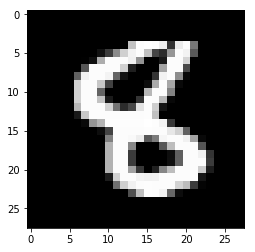

In [817]:
#Show Image
first_image=x_train[0]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [689]:
x_train.shape

(55000, 784)

In [820]:
y_train=np.ones((x_train.shape[0],1))
y_val=np.ones((x_val.shape[0],1))

(array([   0.,    0.,    0.,    0.,    0., 5300.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

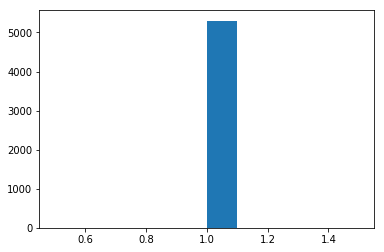

In [821]:
plt.hist(y_train)

In [841]:
#define discriminator and generator if fully connected only

def discri_fully(X,reuse=False):
    with tf.variable_scope("dnn/Dis",reuse=reuse):
        hidden01=tf.layers.dense(X, 300, name="dnn/Dis/hidden001",activation=None, kernel_initializer=initializer)
        hidden01=tf.layers.dense(hidden01, 100, name="dnn/Dis/hidden01",activation=None, kernel_initializer=initializer)
        act_hidden01=tf.nn.leaky_relu(hidden01)
        output=tf.layers.dense(  act_hidden01, 1, name="dnn/Dis/output_final",activation=None)
    return output,tf.nn.sigmoid(output)

def gene_fully(Z,reuse=False):
    with tf.variable_scope("dnn/Gen",reuse=reuse):
        hidden01=tf.layers.dense(Z, 100, name="dnn/Gen/hidden01",activation=tf.nn.leaky_relu, kernel_initializer=initializer)
        hidden01=tf.layers.dense(hidden01, 300, name="dnn/Gen/hidden02",activation=tf.nn.leaky_relu, kernel_initializer=initializer)

        outputg=tf.layers.dense(hidden01, 784, name="dnn/Gen/output_final",activation=tf.nn.tanh)
    return outputg


In [925]:
#define discriminator and generator if conv net
def discri(X,reuse=False):
    with tf.variable_scope("dnn/Dis",reuse=reuse):
        conv=tf.nn.leaky_relu(tf.layers.conv2d_transpose(X, 128, [7, 7],strides=(1, 1), padding='SAME',name="dnn/Dis/conv1"))
        conv=tf.nn.leaky_relu(tf.layers.conv2d_transpose(conv, 64, [14, 14],strides=(2, 2), padding='SAME',name="dnn/Dis/conv2"))
        flat=tf.compat.v1.layers.flatten(conv)
        hidden01=tf.layers.dense(flat, 50, name="dnn/Dis/hidden01",activation=tf.nn.leaky_relu, kernel_initializer=initializer)

        output=tf.layers.dense(hidden01, 1, name="dnn/Dis/output_final",activation=None)
    return output,tf.nn.sigmoid(output)
def gene(Z,reuse=False):
    with tf.variable_scope("dnn/Gen",reuse=reuse):
        hidden01=tf.layers.dense(Z, 7*7*256, name="dnn/Gen/hidden01",activation=tf.nn.leaky_relu, kernel_initializer=initializer)
        conv=tf.nn.leaky_relu(tf.layers.conv2d_transpose(tf.reshape(hidden01,shape=[-1,7,7,256]), 128, [7, 7],strides=(1, 1), padding='SAME'),name="dnn/Gen/conv1")
        conv=tf.nn.leaky_relu(tf.layers.conv2d_transpose(conv, 64, [14, 14],strides=(2, 2), padding='SAME',name="dnn/Gen/conv2"))


        outputg=tf.nn.tanh(tf.layers.conv2d_transpose(conv, 1, [14, 14],strides=(2, 2), padding='SAME',name="dnn/Gen/conv3"))
    return outputg


In [914]:
#test gene for output with correct shape
tf.reset_default_graph()
Z=tf.placeholder(tf.float32,shape=(None,1),name="Z")
tf.reshape(hidden01,shape=[-1,7,7,256])
gene(Z)

<tf.Tensor 'dnn/Gen/Tanh:0' shape=(?, 28, 28, 1) dtype=float32>

In [936]:
#Define Network
tf.reset_default_graph()
X=tf.placeholder(tf.float32,shape=(None,28,28,1),name="X")
Z=tf.placeholder(tf.float32,shape=(None,1),name="Z")

Y=tf.placeholder(tf.float32,shape=(None,1),name="Y")
initializer = tf.contrib.layers.xavier_initializer()

G_sample=gene(Z)
output,predicted=discri(X)
output_gen,predicted_gen=discri(G_sample,reuse=True)


In [937]:
#Define loss
with tf.name_scope("loss"):
    #loss discriminator(target:1 for real and 0 for generated/fake )
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(Y), logits=output)+tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(Y), logits=output_gen)
    weights = tf.trainable_variables()
    loss=tf.reduce_mean(cross_entropy)
    error=loss
    #loss generator(target: 1 for fake when passed to discriminator )
    error_gen=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(Y), logits=output_gen))

In [938]:
#define optimizer (here Adam)
with tf.name_scope("train"):
    optimizer =tf.train.AdamOptimizer(learning_rate=0.00001,beta1=0.9,beta2=0.999,epsilon=1e-08,use_locking=False,name='Adam')
    optimizer2 =tf.train.AdamOptimizer(learning_rate=0.001,beta1=0.9,beta2=0.999,epsilon=1e-08,use_locking=False,name='Adam2')
    train_vars2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="dnn/Gen")
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="dnn/Dis")
    print(train_vars)
    print(train_vars2)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(error,var_list=train_vars)
        training_op2 = optimizer.minimize(error_gen,var_list=train_vars2)
        

[<tf.Variable 'dnn/Dis/dnn/Dis/conv1/kernel:0' shape=(7, 7, 128, 1) dtype=float32_ref>, <tf.Variable 'dnn/Dis/dnn/Dis/conv1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'dnn/Dis/dnn/Dis/conv2/kernel:0' shape=(14, 14, 64, 128) dtype=float32_ref>, <tf.Variable 'dnn/Dis/dnn/Dis/conv2/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'dnn/Dis/dnn/Dis/hidden01/kernel:0' shape=(200704, 50) dtype=float32_ref>, <tf.Variable 'dnn/Dis/dnn/Dis/hidden01/bias:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'dnn/Dis/dnn/Dis/output_final/kernel:0' shape=(50, 1) dtype=float32_ref>, <tf.Variable 'dnn/Dis/dnn/Dis/output_final/bias:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'dnn/Gen/dnn/Gen/hidden01/kernel:0' shape=(1, 12544) dtype=float32_ref>, <tf.Variable 'dnn/Gen/dnn/Gen/hidden01/bias:0' shape=(12544,) dtype=float32_ref>, <tf.Variable 'dnn/Gen/conv2d_transpose/kernel:0' shape=(7, 7, 128, 256) dtype=float32_ref>, <tf.Variable 'dnn/Gen/conv2d_transpose/bias:0' shape=(128,) dtype=float3

In [939]:
#metrics for fun
with tf.name_scope("eval"):
    correct_pred = tf.equal(tf.round(predicted), tf.ones_like(Y))
    acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    _,auc = tf.metrics.auc(labels=tf.ones_like(Y),predictions=predicted)
    correct_pred_gen = tf.equal(tf.round(predicted_gen), tf.ones_like(Y))
    acc_gen = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    _,auc_gen = tf.metrics.auc(labels=tf.ones_like(Y),predictions=predicted_gen)

In [952]:
sess.close()

In [953]:
#in case we want to save the model
saver=tf.train.Saver()
loc=tf.local_variables_initializer()


In [954]:
#init session and in case we want to keep track of the metrics over the epochs 
init=tf.global_variables_initializer()
sess = tf.InteractiveSession(config=tf.ConfigProto(device_count={ "CPU": 44}))
init.run()
loc.run()
auc_tab=[]
accuracy_tab=[]
loss_tab=[]
epoch_tab=[]
auc_tab_val=[]
accuracy_tab_val=[]
loss_tab_val=[]

In [955]:
#Own mini batch generator
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [956]:
x_train.shape

(5300, 784)

In [ ]:
#learning heursitics plus display of scores over training
batch_size=100
best_auc=0
for epoch in range(200):
    iteration=0
    z_batch=np.random.normal(0, 1, (batch_size,1))

    for x_batch,y_batch in shuffle_batch(x_train, y_train, batch_size):
        sess.run(training_op,feed_dict={Z:z_batch,X:x_batch.reshape(-1,28,28,1),Y:y_batch})
        print("%d ITERATION:%d/%d "%(epoch,iteration,len(x_train)//batch_size),end='\r')
        iteration+=1
    #40 = arbitrarly choosen
    for i in range(40):
        sess.run(training_op2,feed_dict={Z:z_batch,X:x_batch.reshape(-1,28,28,1),Y:y_batch})
    
    loc.run()
    loss_train,acc_train,auc_train=sess.run([loss,acc,auc],feed_dict={Z:z_batch,X:x_batch.reshape(-1,28,28,1),Y:y_batch})
    print(epoch,"Train accuracy:",acc_train,"Loss:",loss_train,"AUC:",auc_train)
    loc.run()
    loss_train,acc_train,auc_train=sess.run([error_gen,acc_gen,auc_gen],feed_dict={Z:z_batch,X:x_batch.reshape(-1,28,28,1),Y:y_batch})
    print(epoch,"Train accuracy:",acc_train,"Loss:",loss_train,"AUC:",auc_train)

    auc_tab.append(auc_train)
    accuracy_tab.append(acc_train)
    epoch_tab.append(epoch)
    loss_tab.append(loss_train)
    #validation
    loc.run()
    z_batch=np.random.normal(0, 1, (974,1))
    loc.run()
    loss_val,acc_val,auc_val=sess.run([loss,acc,auc],feed_dict={Z:z_batch,X:x_val.reshape(-1,28,28,1),Y:y_val})
    
    auc_tab_val.append(auc_val)
    accuracy_tab_val.append(acc_val)
    loss_tab_val.append(loss_val)
    best_auc=auc_val
    loc.run()
    print(epoch,"Validation accuracy:",acc_val,"Loss:",loss_val,"AUC:",auc_val)
    loss_val,acc_val,auc_val=sess.run([error_gen,acc_gen,auc_gen],feed_dict={Z:z_batch,X:x_val.reshape(-1,28,28,1),Y:y_val})
    print(epoch,"Validation accuracy:",acc_val,"Loss:",loss_val,"AUC:",auc_val)

    print("\n")

In [ ]:
save_path = saver.save(sess, "~/try.ckpt")

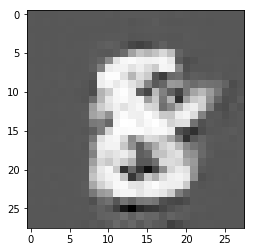

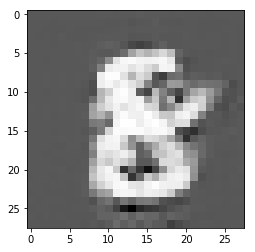

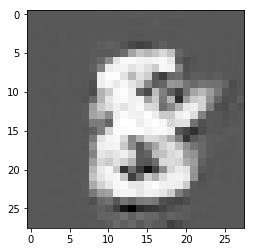

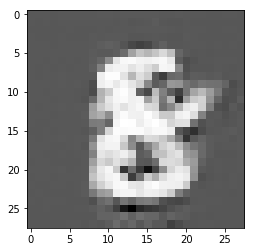

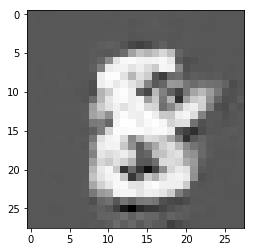

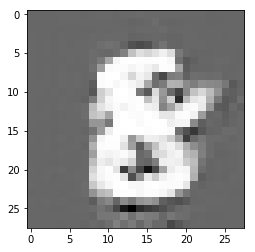

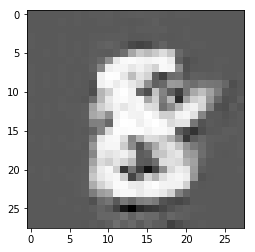

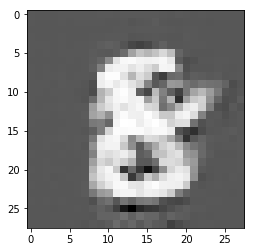

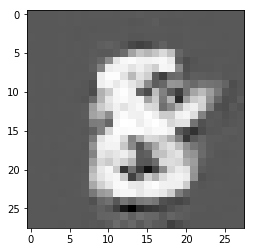

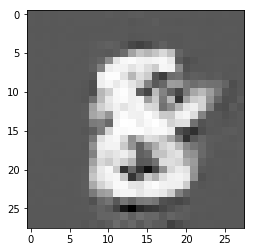

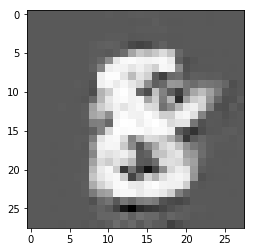

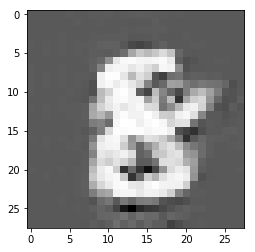

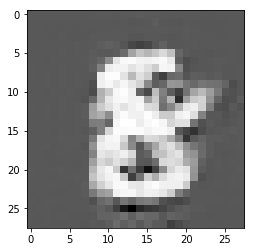

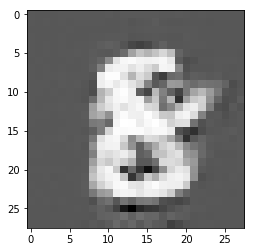

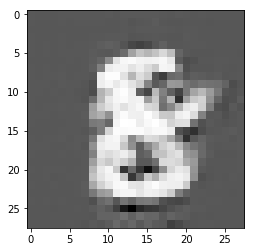

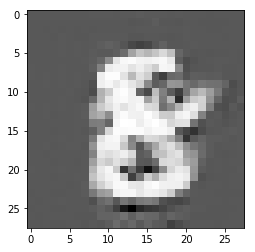

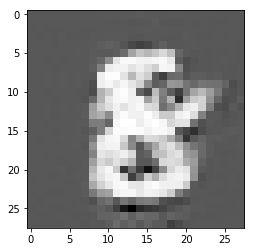

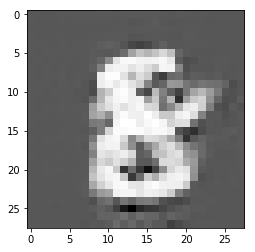

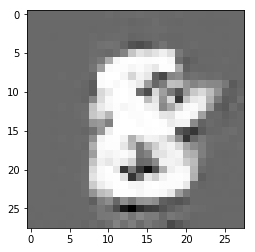

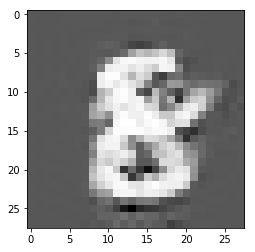

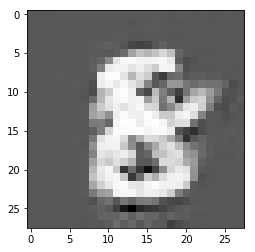

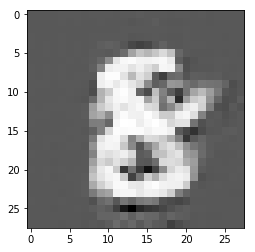

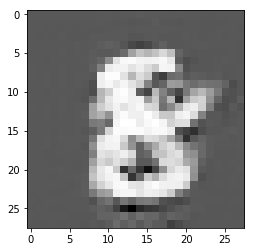

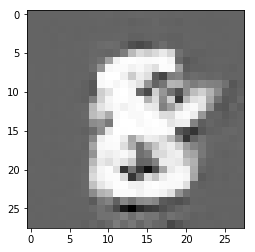

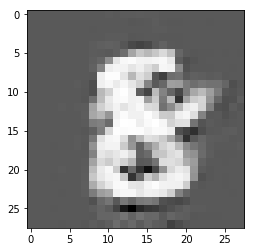

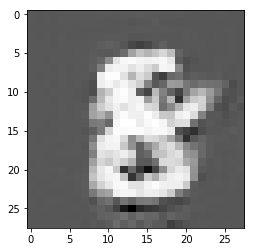

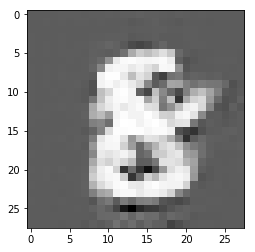

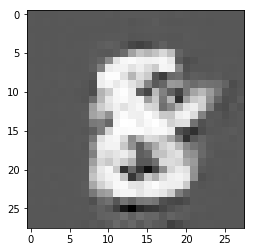

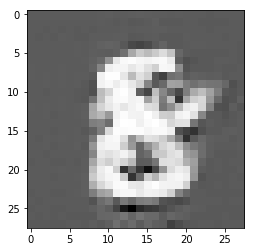

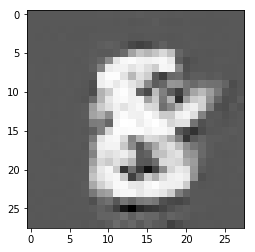

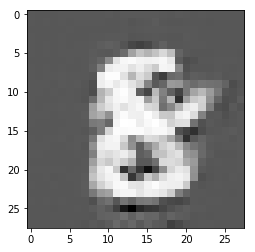

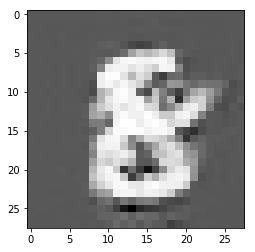

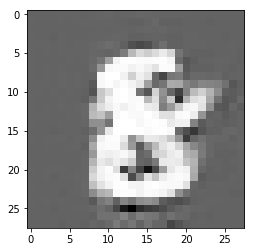

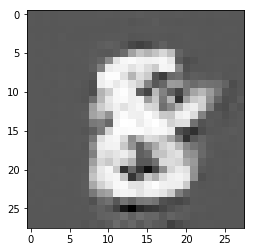

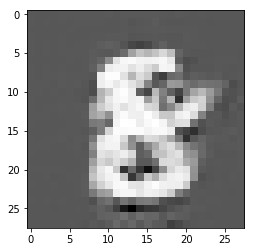

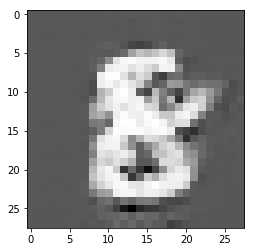

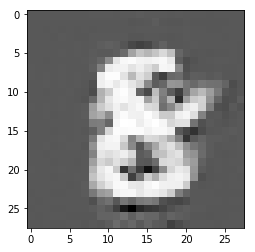

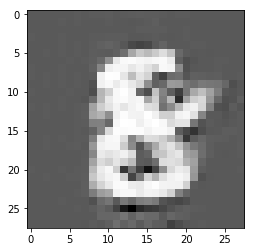

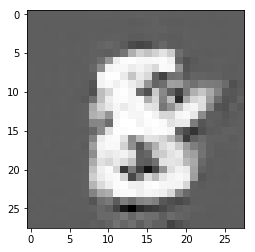

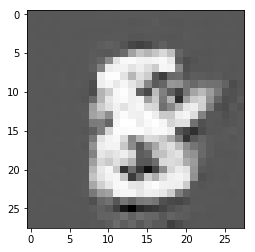

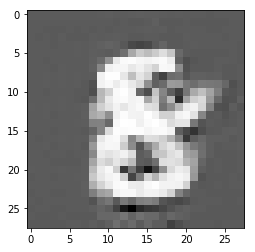

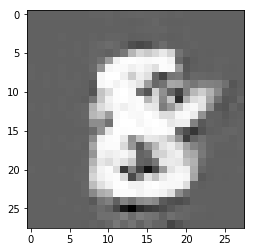

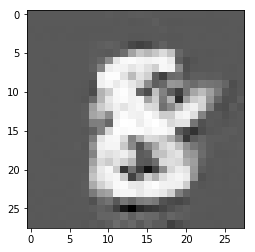

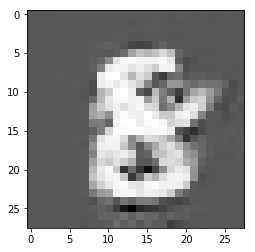

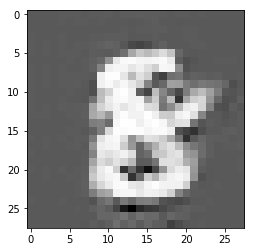

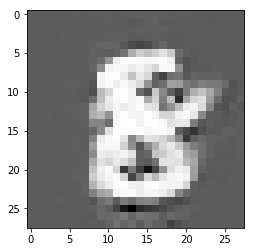

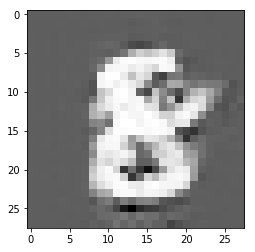

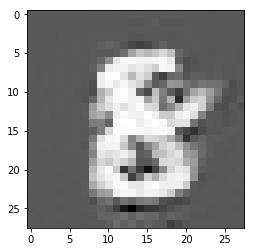

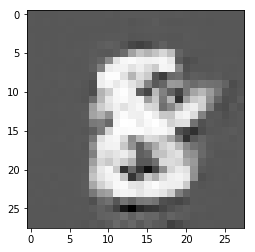

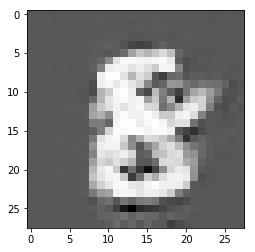

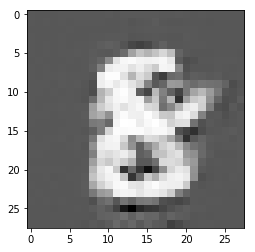

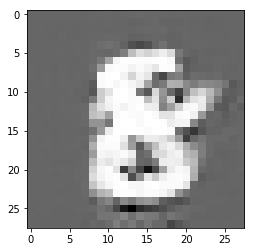

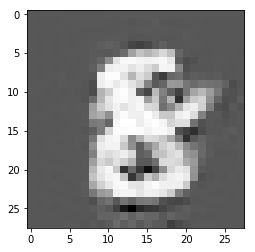

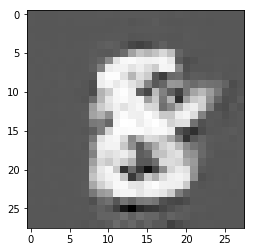

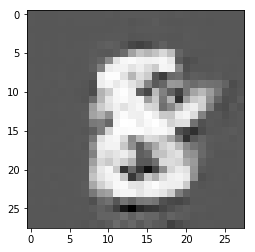

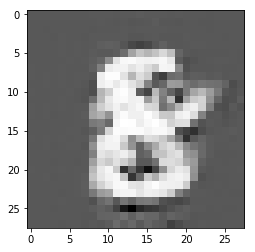

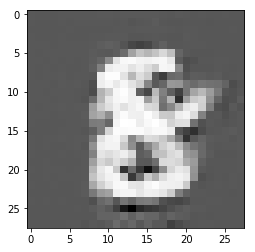

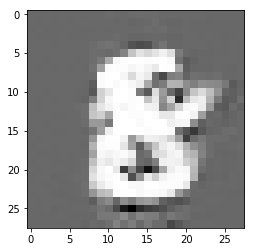

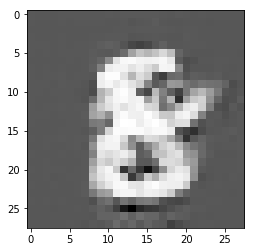

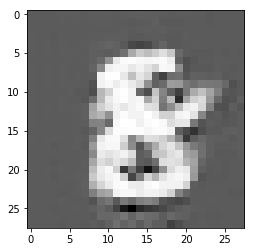

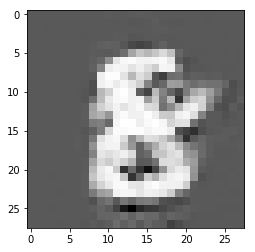

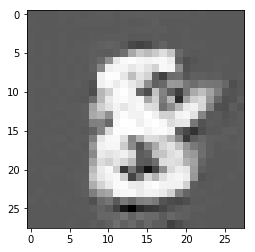

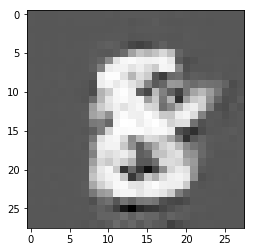

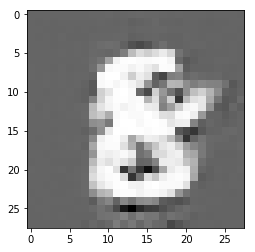

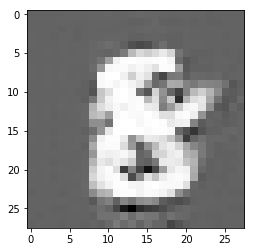

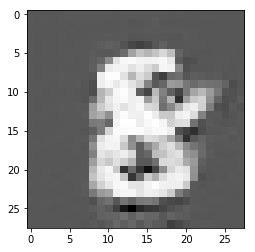

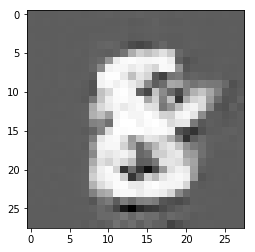

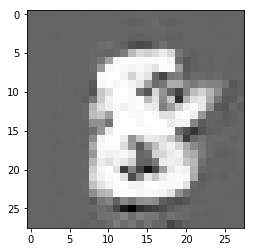

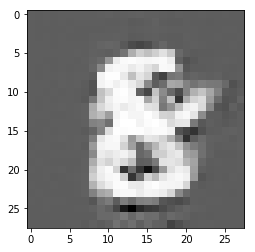

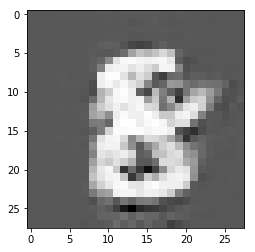

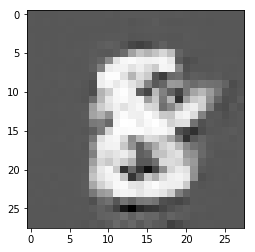

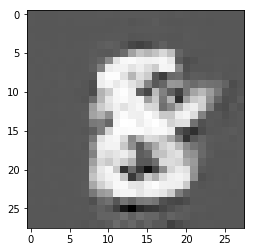

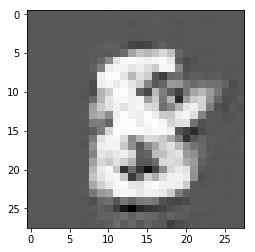

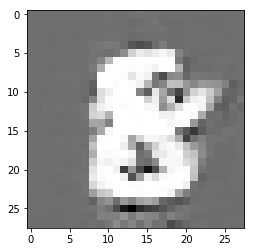

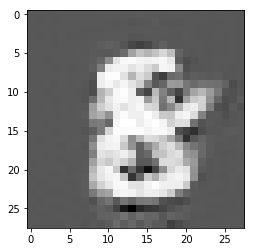

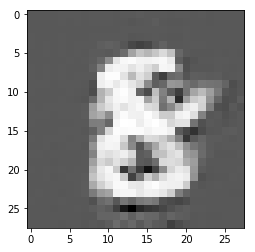

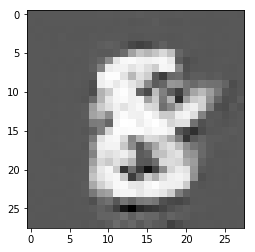

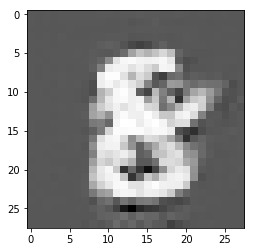

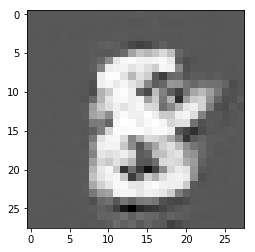

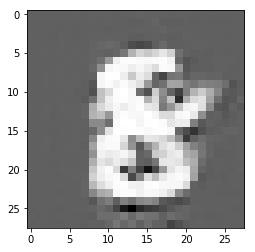

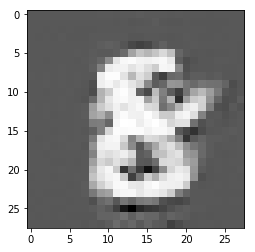

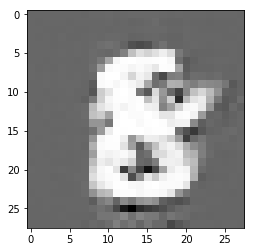

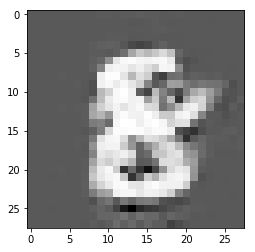

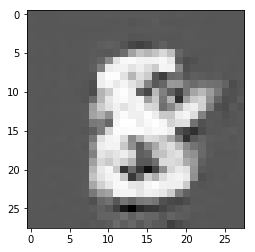

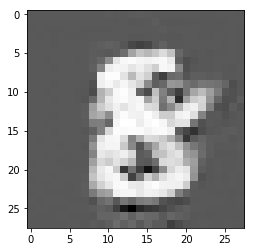

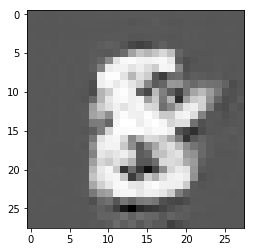

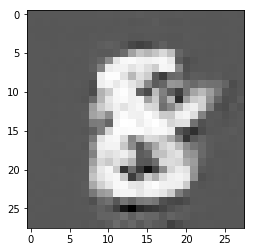

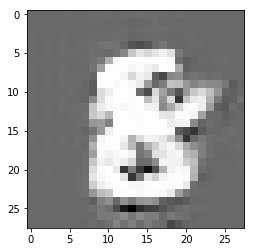

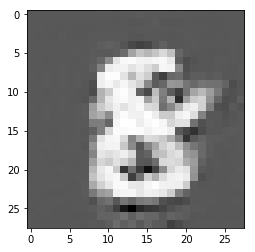

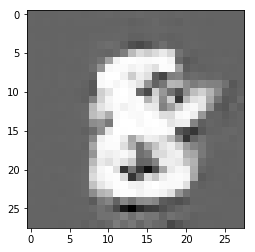

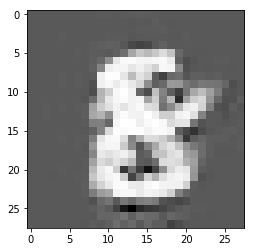

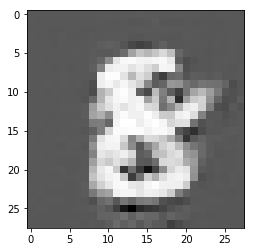

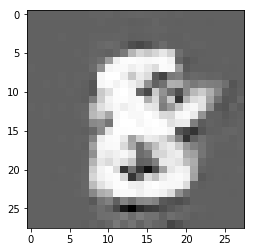

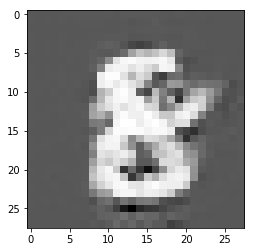

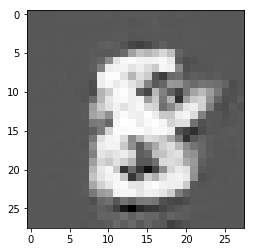

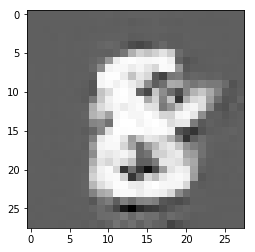

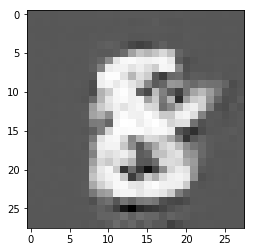

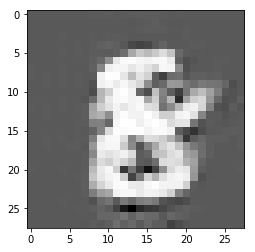

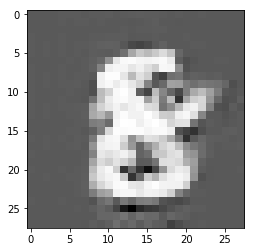

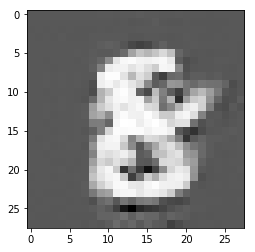

In [967]:
#generate few fake digits to see what it looks like...
t=sess.run(G_sample,feed_dict={Z:np.random.normal(0, 1, (batch_size,1))})
for i in t:
    first_image=i
    first_image = np.array(first_image, dtype='float')
    pixels = first_image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()